<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab  


*Authors:*
 - Joseph Nelson (DC)      
 - Boom Devahastin Na Ayudhya  (NYC)   
 - Bethany Poulin (Boston) 



---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for otZhers to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

A) fortunately, it all seems pretty clean!  Preprocessing below. 

In [74]:
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [75]:
data.shape

(10244, 4)

In [76]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [77]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [78]:
data.isna().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [79]:
data.index = pd.to_datetime(data.index)

In [80]:
# def dataprep(data):
#     dataprep_info = "Here is our data head", data.head(),
#     "is there any null values?", data.isnull().sum,
#     "is there any na values?", data.isnull().sum,
#     "Our number of X and Y variables, respectively, are :", df.shape
#     return dataprep_info

In [81]:
#dataprep(data)

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**



In [82]:
mask = data['Store'] == 1
data = data[mask]
#Weekly_Sales = data[data['Store'] == 1]

Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())


In [83]:
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [84]:
type(Weekly_Sales)

pandas.core.frame.DataFrame

In [85]:
Weekly_Sales = Weekly_Sales.resample('W').sum()

In [86]:
Weekly_Sales

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68
2010-03-14,1439541.59
2010-03-21,1472515.79
2010-03-28,1404429.92
2010-04-04,1594968.28


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

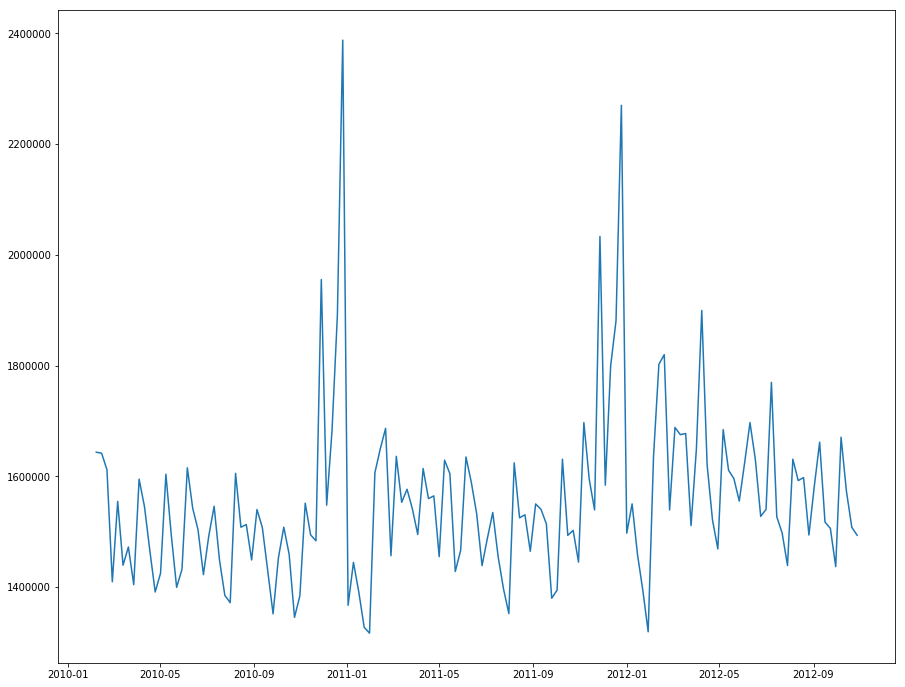

In [87]:
plt.figure(figsize = (15, 12))
plt.plot(Weekly_Sales.index, Weekly_Sales['Weekly_Sales'])
plt.show()

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [88]:
Weekly_Sales_rolling4weeks = Weekly_Sales.rolling(4).mean()

In [89]:
Weekly_Sales_rolling_quarterly = Weekly_Sales.rolling(13).mean()

In [90]:
Weekly_Sales_rolling_annual = Weekly_Sales.rolling(52).mean()

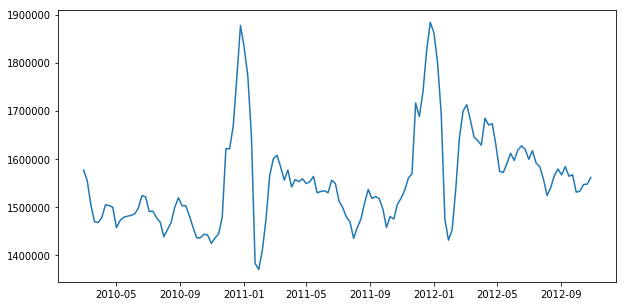

In [91]:
plt.figure(figsize = (10, 5))
plt.plot(Weekly_Sales_rolling4weeks['Weekly_Sales'])
plt.show()

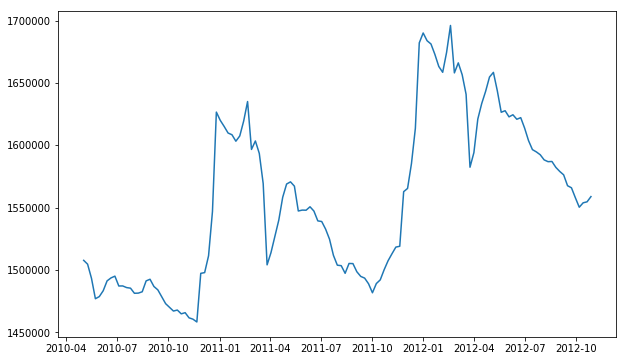

In [92]:
plt.figure(figsize = (10, 6))
plt.plot(Weekly_Sales_rolling_quarterly.index, Weekly_Sales_rolling_quarterly['Weekly_Sales'])
plt.show()

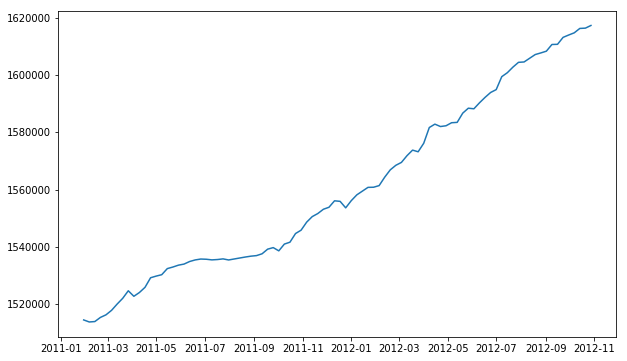

In [93]:
plt.figure(figsize = (10, 6))
plt.plot(Weekly_Sales_rolling_annual.index, Weekly_Sales_rolling_annual['Weekly_Sales'])
plt.show()

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* There are spikes in sales seasonally, and in general, sales go up over time.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [94]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=1)

0.3021582794113126

In [95]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=2)

0.12741313055390097

In [96]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=4)

0.2381929408831175

In [97]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=8)

0.08116514893767034

In [98]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=13)

0.10169228501987719

In [99]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=26)

0.08811927987160197

In [100]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=39)

-0.02575010984436285

In [101]:
Weekly_Sales['Weekly_Sales'].autocorr(lag=52)

0.8953760294777008

**3b. What can you say about the series based on these autocorrelations?**

Answer: After 1 week, autocorrelations typically decline, climbing back up at certain intervals, but weekly sales exactly one year (52 weeks) apart are then again, very strongly correlated.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

In [102]:
from pandas.plotting import autocorrelation_plot

In [103]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

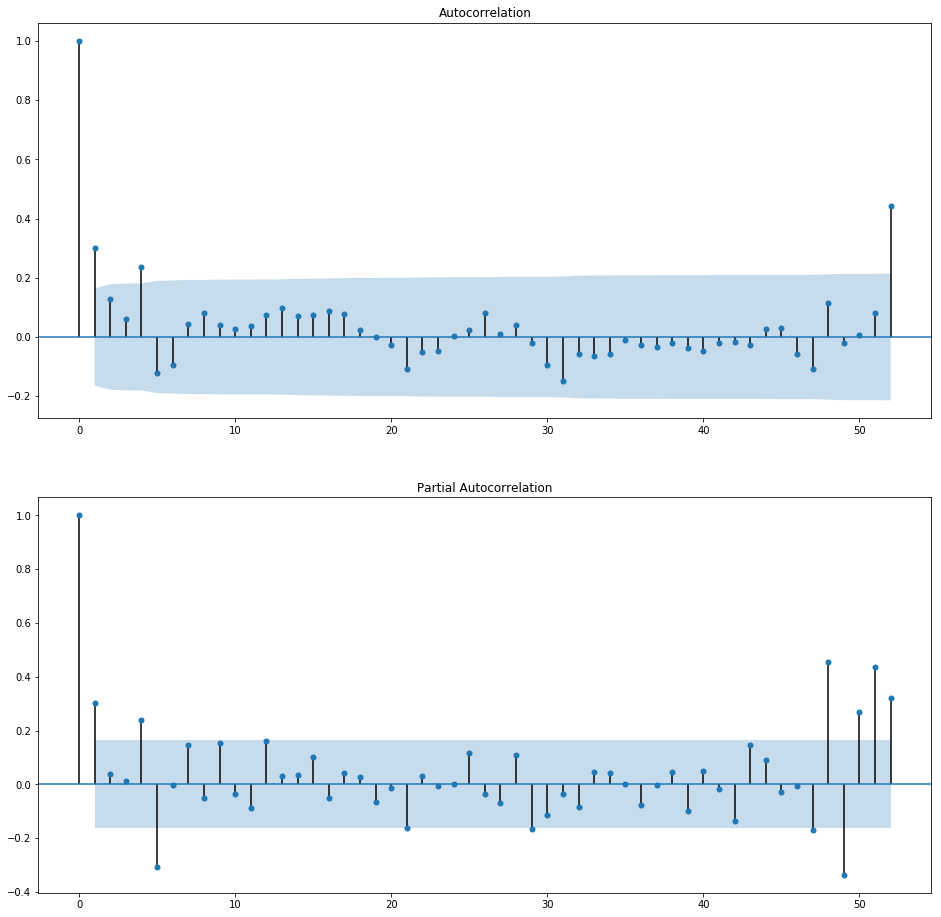

In [104]:
# autocorrelation_plot(data.Weekly_Sales) what makes this get stuck?

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:The blue shade in both represents the confidence interval - all points within are statistically insignificant findings.  

In an autocorrelation and pacf, there are positive correlations at lag 1 and 4.  At lag 5 in the pacf plot there's a significant negative correlation, which I'm not sure how to interpret.  Possibly clearance and sales intervals that creat some sort of oscillation between values 5 weeks apart? 

In an autocorrelation and partial autocorrelation, there are correlations towards the end of the year, 52 weeks from a given point, demonstrating a seasonal sales cycle. 

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: The above correlations help us identify our p and q values. 

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [105]:
Weekly_Sales.shape

(143, 1)

In [106]:
Weekly_Sales.shape[0]*.75

107.25

In [107]:
train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [108]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [109]:
train_values = train['Weekly_Sales'].values
train_dates = train.index

In [110]:
test_values = test['Weekly_Sales'].values
test_dates = test.index

ar1_model = AR(train_values, train_dates).fit()

# Create start and end dates for predictions
start = test.index[0]
end = test.index[-1]

#Generate predictions

ar1_preds = ar1_model.predict()

In [111]:
AR1_pred = ar1_model.predict(start = start,
                       end = end)

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [112]:
date_list =  pd.date_range(start, periods=35, freq ='W')
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])


In [113]:
error = mean_squared_error(test_values, preds)

In [114]:
#mse_train1 = mean_squared_error(train['Weekly_Sales'], ar1_preds)


**6c. How effective do you think this `AR(1)` model is?**

In [115]:
#Functions from the solution code
print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
MSE relative to minimum values in series: 7467.72.
MSE relative to maximum values in series: 4118.28.


Answer: it's ok, my model has a large MSE and there's a lot of variance between the train and test set, but compared to the large volume of sales, it is somewhat predictive.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

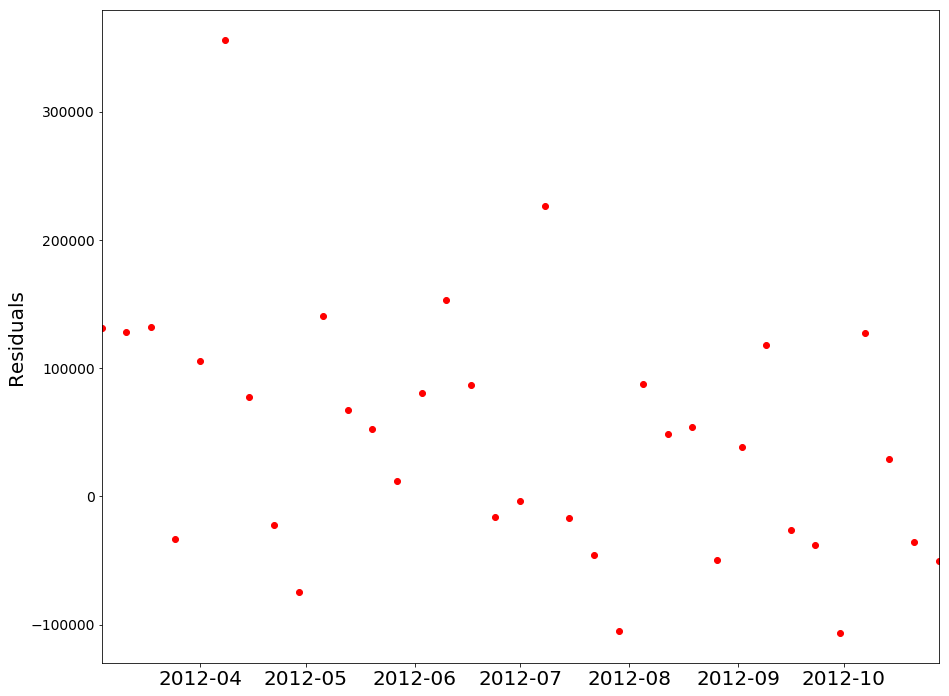

In [117]:
#Figure size
plt.figure(figsize=(15,12))

#Residuals 
residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

#Scatterplot of residuals
plt.scatter(test['Weekly_Sales'].index, residuals, c ='red')

#Labels and axes
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

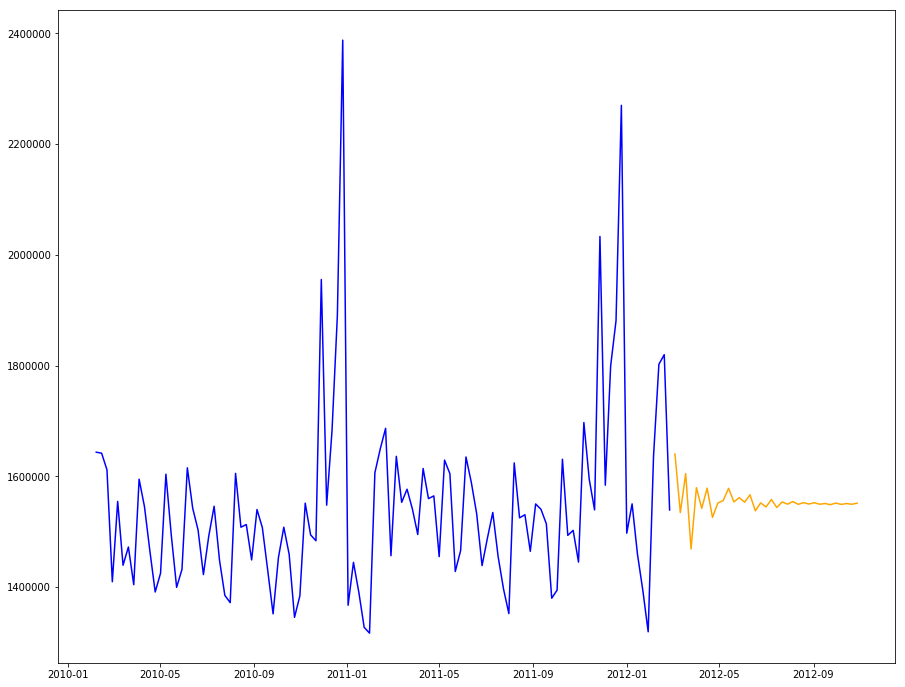

In [118]:
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer: It seems the model gets somewhat more accurate over time, towards the end of the year, as residuals demonstrate early on the model predicts too high and centers closer to zero over time.  It does not accurately predict variation over time we would expect, however, and flattens it.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [48]:
#Fit the AR2 model
AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()


In [49]:
#Our predictions
AR2_pred = AR2.predict(start = start,
                       end = end)

In [50]:
def train_test_plot(train, test):
    plt.figure(figsize=(15, 12))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

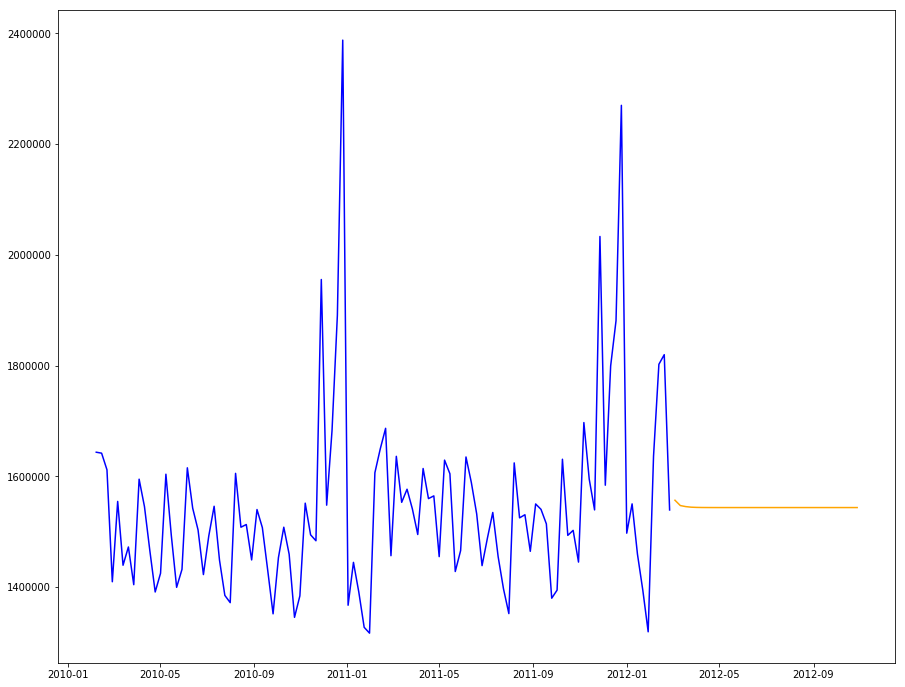

In [51]:
#Evaluate our model 
preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

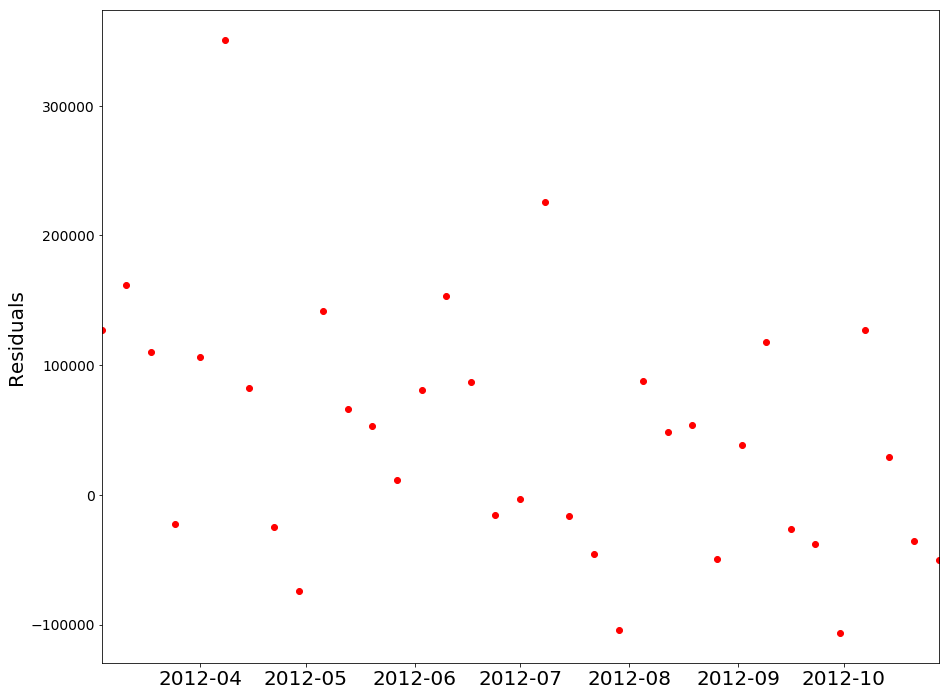

In [54]:
#Figure size
plt.figure(figsize=(15,12))

#Residuals 
residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

#Scatterplot of residuals
plt.scatter(test['Weekly_Sales'].index, residuals, c ='red')

#Labels and axes
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8b. How did your results change?**

Answer: It is very flat and inaccurate.  

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

Training MSE: 21365569166.6247
Testing MSE: 11347833863.230904


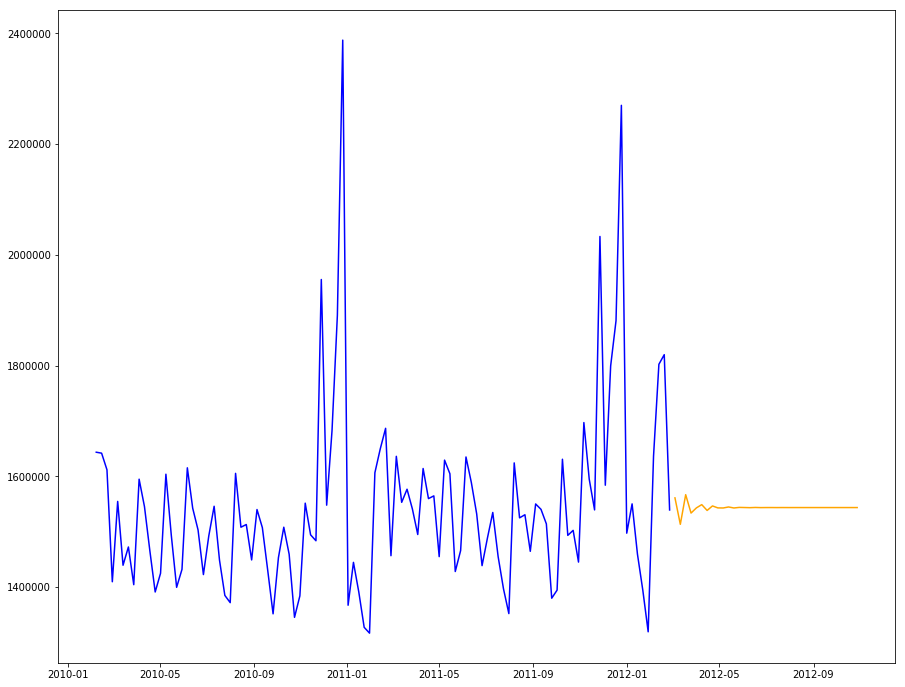

In [55]:
#Fit the model
AR2_2 = ARIMA(endog = train_values,
              dates = train_dates,
              order = (2,0,2)).fit()

# Generate predictions.
AR2_2_pred = AR2_2.predict(start = start,
                           end = end)

# Evaluate our model
print(f'Training MSE: {mean_squared_error(train_values, AR2_2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_2_pred)}')

preds = pd.DataFrame(AR2_2_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

In [229]:
mse_test2_2

12540984443.812243

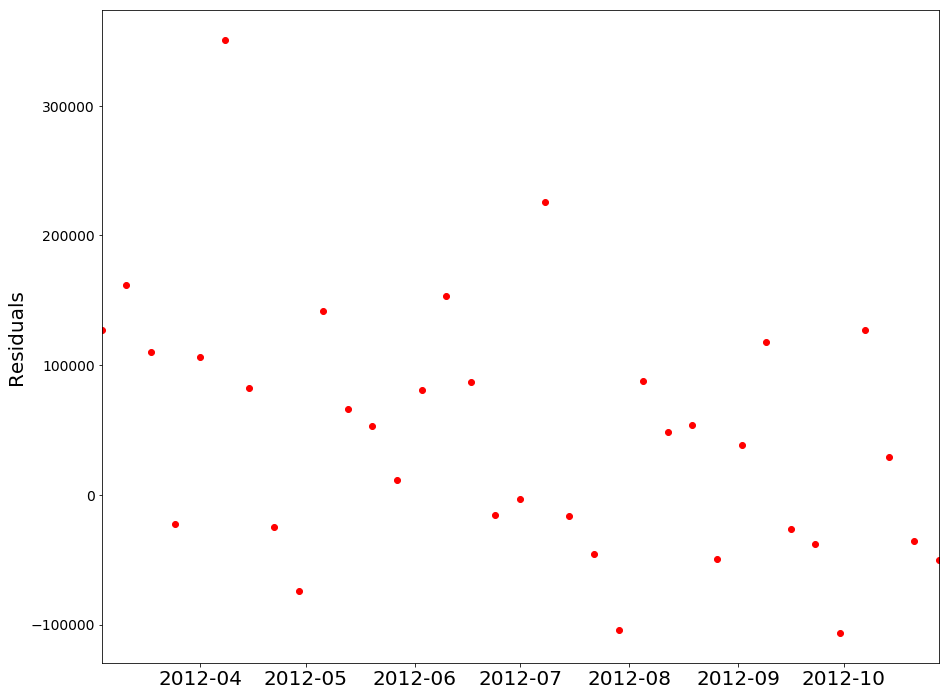

In [57]:
plt.figure(figsize=(15,12))

#Residuals 
residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

#Scatterplot of residuals
plt.scatter(test['Weekly_Sales'].index, residuals, c ='red')

#Labels and axes
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: The residuals are still similar, but the predicted values in our line plot are still very flat and inaccurate. 

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [58]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [59]:
interpret_dftest(adfuller(train['Weekly_Sales']))

Test Statistic   -4.741809
p-value           0.000070
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: The very low p value indicates very high significance - we reject the null hypothesis, and accept the alternative hypothesis that the data is stationary. 

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [60]:
Weekly_Sales['differenced1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['differenced2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['differenced3'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales.head()

,Weekly_Sales,differenced1,differenced2,differenced3
Date,,,,
2010-02-07,1643690.90,NaN,NaN,NaN
2010-02-14,1641957.44,-1733.46,NaN,NaN
2010-02-21,1611968.17,-29989.27,-31722.73,NaN
2010-02-28,1409727.59,-202240.58,-232229.85,-233963.31
2010-03-07,1554806.68,145079.09,-57161.49,-87150.76


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [66]:
print('Original Data')
print('')
interpret_dftest((Weekly_Sales['Weekly_Sales']))
print('')
for diff in range(1, 4):
    print(f'Data Differenced by d = {diff}')
    print('')
    interpret_dftest(([f'diff_{diff}']))
    print('')

Original Data


Data Differenced by d = 1



ValueError: Length of passed values is 1, index implies 2

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [69]:
ARIMA212 = ARIMA(endog = train_values, dates = train_dates, order = (2,1,2)).fit()

ARIMA212_pred = ARIMA212.predict(start=start, end=end)

mean_squared_error(test_values, ARIM212_pred)


LinAlgError: SVD did not converge

**11b. Interpret the results from the last answer.**


Answer: "SVD did not converge" means this new d value does not work as a hyperparameter, and the model can't be completed.   

#### 12. BONUS: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

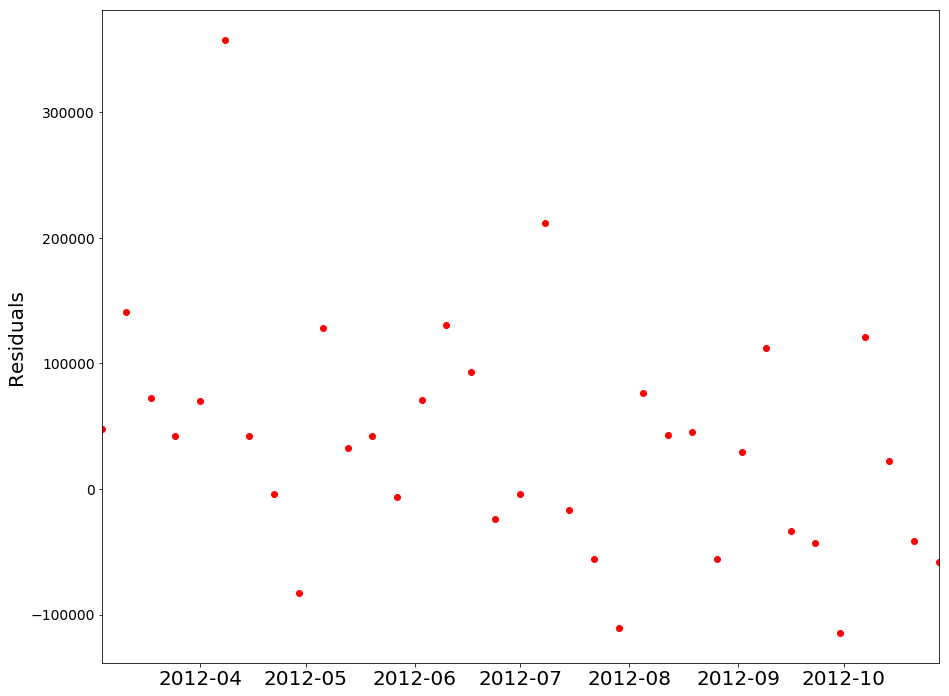

In [119]:
#Figure size
plt.figure(figsize=(15,12))

#Residuals 
residuals = test['Weekly_Sales'].values - preds['Weekly Sales'].values

#Scatterplot of residuals
plt.scatter(test['Weekly_Sales'].index, residuals, c ='red')

#Labels and axes
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

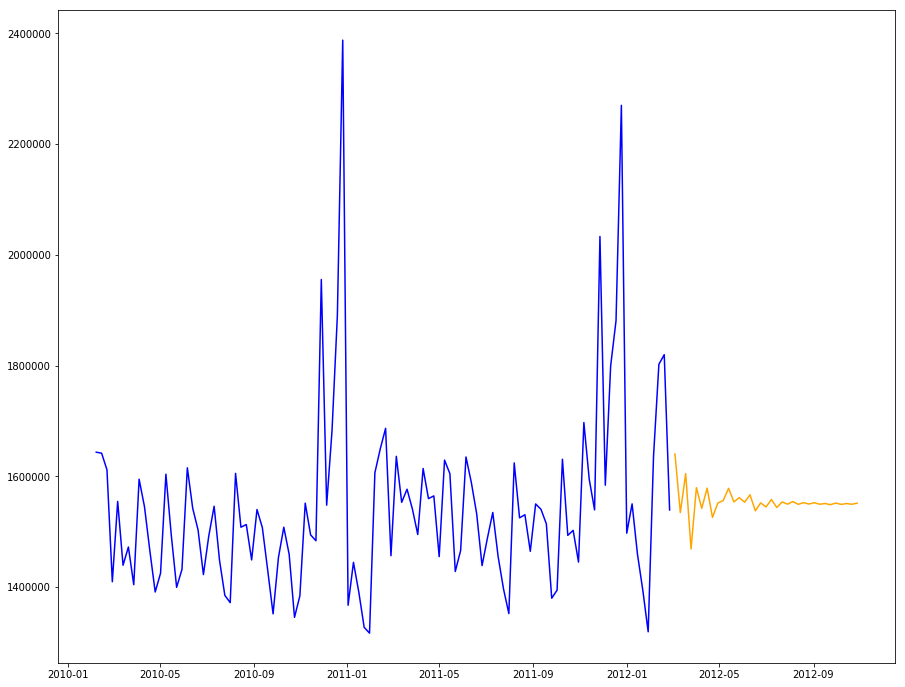

In [120]:
preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

train_test_plot(train, preds)

In [121]:
print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')
print(f'MSE relative to minimum values in series: {round(error / Weekly_Sales["Weekly_Sales"].min(),2)}.')
print(f'MSE relative to maximum values in series: {round(error / Weekly_Sales["Weekly_Sales"].max(),2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
MSE relative to minimum values in series: 7467.72.
MSE relative to maximum values in series: 4118.28.


**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: On average it performs fine, but it does not express expected variance over time well, as it flatlines and averages out.

**13c. How might you improve it?**

Answer:
There are probably other parameters that can be tuned, or perhaps a more complex model. 

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: